## Signac RDF Function

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import freud
import signac
import gsd
import hoomd
import gsd.pygsd
import gsd.hoomd
import scipy
from scipy import signal
import time
import os
import cycler
from scipy.stats import linregress
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
import cme_lab_utils
from cme_lab_utils import gsd_utils

#### Give a file path to pull the trajectory from

In [2]:
ptb7_path = "/home/gwenwhite/cmelab/ptb7-itic/ptb7-project/"
ptb7_project = signac.get_project(ptb7_path)

#### Narrow results with state dictionary 

In [3]:
state_dict={"size": "small", 
            "process": "quench",
            "density":1.2,
            "molecule":"PTB7_5mer_smiles"}

job_list= ptb7_project.find_jobs(state_dict)

#### Create a .txt file of RDF data

In [35]:
def rdf_to_txt(job_list):
    for job in job_list:
        job_path = job.fn('trajectory.gsd')
        A_name = "ss"
        B_name = "ss"
        rdf = gsd_utils.gsd_rdf(job_path, A_name, B_name, rmin=0.01, rmax=6)
        '''gsd_utils.gsd_rdf is a function from cme_lab_utils that creates the RDF'''
        x = rdf.bin_centers
        y = rdf.rdf
        filename = job.fn('{}-{}-uncorr-rdf-data.txt'.format(A_name[0], B_name[0]))
        np.savetxt(filename, np.transpose([x,y]), delimiter=',', header= "bin_centers, rdf")
        print(".txt file created for job:")
        print(job)

In [ ]:
rdf_to_txt(job_list)

.txt file created for job:
2f8929ad21c5e741ef1cfec1f5034498
.txt file created for job:
803d096ee564593fa490f1fba8900d25
.txt file created for job:
ea4edb137779c6d44114a6dd58294b06
.txt file created for job:
98f3657dbf8217955cc9d96607ecca3c
.txt file created for job:
45df65ebfeea0e861945452055c4a1e8


#### specify how txt file can be plotted

In [16]:
def plot_txt(constant="den"): 
    if constant == "den":
        state_dict['density.$lt'] = 1.3
        fig = plt.figure()
        ax = plt.subplot(111)
        color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
        plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
        for kT,job in job_list.groupby('kT_reduced'):
            job = list(job)[0]
            A_name = "ss"
            B_name = "ss"
            txt_path= job.fn('{}-{}-uncorr-rdf-data.txt'.format(A_name[0], B_name[0]))
            line= np.genfromtxt(txt_path, names=True, delimiter=",")
            x= line["bin_centers"]
            y= line["rdf"]
            plt.plot(x, y, label=kT)
            plt.xlabel("r (A.U.)")
            plt.ylabel("g(r)")
            plt.title("%s and %s's at %sden" % (A_name, B_name, job.sp['density']), fontsize=16)
            plt.legend(bbox_to_anchor=(1.5, 1), ncol=2)
    elif constant == "temp":
        state_dict['kT_reduced.$lt'] = 2.5
        fig = plt.figure()
        ax = plt.subplot(111)
        color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
        plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
        for den,job in job_list.groupby('density'):
            job = list(job)[0]
            A_name = "ss"
            B_name = "ss"
            txt_path= job.fn('{}-{}-uncorr-rdf-data.txt'.format(A_name[0], B_name[0]))
            line= np.genfromtxt(txt_path, names=True, delimiter=",")
            x= line["bin_centers"]
            y= line["rdf"]
            plt.plot(x, y, label=den)
            plt.xlabel("r (A.U.)")
            plt.ylabel("g(r)")
            plt.title("%s and %s's at %sden" % (A_name, B_name, job.sp['kT_reduced']), fontsize=16)
            plt.legend(bbox_to_anchor=(1.5, 1), ncol=2)
    else:
        print("the variable constant must be temp or den")

#### Plot your txt file(s)

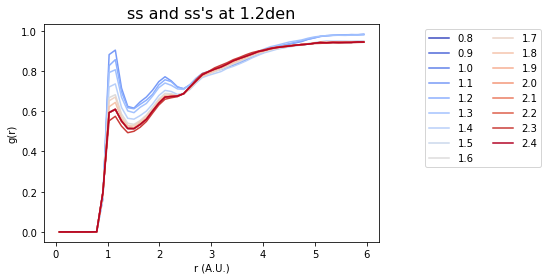

In [17]:
plot_txt(constant="den") #constant= "den" for density or "temp" for temperature